In [ ]:
!pip install numpy==1.23.5

In [ ]:
!pip install optuna

In [ ]:
!pip install --upgrade pmdarima

In [ ]:
from pmdarima import auto_arima

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost
import lightgbm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
# For reading stock data from yahoo
from pandas_datareader.data import DataReader
# For time stamps
from datetime import datetime

In [ ]:
# Load the first dataset
columns=['Date','Category','News']
ndf = pd.read_csv("india-news-headlines.csv", names=columns, on_bad_lines='skip', engine='python') # Added on_bad_lines='skip' and engine='python'

In [ ]:
print('Showing part of the whole dataset:')
ndf.head(5)

Showing part of the whole dataset:


,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa


In [ ]:
ndf.drop(0, inplace=True)
ndf.drop('Category', axis = 1, inplace=True)
print('Showing part of the whole dataset:')
ndf.head(-5)

Showing part of the whole dataset:


,Date,News
1,20010102,Status quo will not be disturbed at Ayodhya; s...
2,20010102,Fissures in Hurriyat over Pak visit
3,20010102,America's unwanted heading for India?
4,20010102,For bigwigs; it is destination Goa
5,20010102,Extra buses to clear tourist traffic
...,...,...
34866,20011003,Round one to Chavan; CM stalls dezoning
34867,20011003,SI escapes from naxals
34868,20011003,Food-for-work figures bogus
34869,20011003,Misra urges young doctors to be GPs


In [ ]:
# Load the second dataset
hisdf = pd.read_csv("^BSESN.csv")
hisdf.head(-5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-12-17,41052.359375,41401.648438,41005.179688,41352.171875,41352.171875,19000.0
1,2019-12-18,41442.750000,41614.769531,41358.468750,41558.570313,41558.570313,24300.0
2,2019-12-19,41571.820313,41719.289063,41456.398438,41673.921875,41673.921875,33300.0
3,2019-12-20,41746.199219,41809.960938,41636.109375,41681.539063,41681.539063,33600.0
4,2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,41642.660156,6200.0
...,...,...,...,...,...,...,...
242,2020-12-04,44665.910156,45148.281250,44665.910156,45079.550781,45079.550781,27600.0
243,2020-12-07,45099.921875,45458.921875,45024.468750,45426.968750,45426.968750,18700.0
244,2020-12-08,45568.800781,45742.230469,45335.171875,45608.511719,45608.511719,18200.0
245,2020-12-09,45891.039063,46164.101563,45792.011719,46103.500000,46103.500000,20700.0


In [ ]:
# Convert the 'Date' column to datetime objects before grouping
ndf["Date"] = pd.to_datetime(ndf["Date"], format='%Y%m%d', errors='coerce')

# Filter out rows where the 'Date' conversion resulted in NaT (Not a Time)
ndf = ndf.dropna(subset=['Date'])
# Fill NaN values in the 'News' column with empty strings before grouping
ndf['News'] = ndf['News'].fillna('')

# Group the headlines for each day
ndf['News'] = ndf.groupby(['Date'])['News'].transform(lambda x: ' '.join(x))
ndf = ndf.drop_duplicates(subset=['Date'])
ndf.reset_index(inplace=True, drop=True)

In [ ]:
# Group the headlines for each day
ndf['News'] = ndf.groupby(['Date']).transform(lambda x : ' '.join(x))
ndf = ndf.drop_duplicates()
ndf.reset_index(inplace=True,drop=True)

In [ ]:
ndf

,Date,News
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-03,Powerless north India gropes in the dark Think...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...
3,2001-01-05,Light combat craft takes India into club class...
4,2001-01-06,Light combat craft takes India into club class...
...,...,...
228,2001-09-29,138 SIMI activists held in Maharashtra Progres...
229,2001-09-30,Lawyers urged to eschew path of agitation Dips...
230,2001-10-01,IAF picks Bangalore to set up engineering coll...
231,2001-10-02,News Briefs It was a long; excruciating wait a...


In [ ]:
# Check for any duplicated values
ndf.isnull().sum()

,0
Date,0
News,0


In [ ]:
len(ndf)

233

In [ ]:
hisdf=hisdf[["Date","Open","High","Low","Close","Volume"]]
hisdf.head(-5)

,Date,Open,High,Low,Close,Volume
0,2019-12-17,41052.359375,41401.648438,41005.179688,41352.171875,19000.0
1,2019-12-18,41442.750000,41614.769531,41358.468750,41558.570313,24300.0
2,2019-12-19,41571.820313,41719.289063,41456.398438,41673.921875,33300.0
3,2019-12-20,41746.199219,41809.960938,41636.109375,41681.539063,33600.0
4,2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,6200.0
...,...,...,...,...,...,...
242,2020-12-04,44665.910156,45148.281250,44665.910156,45079.550781,27600.0
243,2020-12-07,45099.921875,45458.921875,45024.468750,45426.968750,18700.0
244,2020-12-08,45568.800781,45742.230469,45335.171875,45608.511719,18200.0
245,2020-12-09,45891.039063,46164.101563,45792.011719,46103.500000,20700.0


In [ ]:
# Check for common information of the second dataset
hisdf["Date"]= pd.to_datetime(hisdf["Date"])
hisdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    252 non-null    datetime64[ns]
 1   Open    250 non-null    float64       
 2   High    250 non-null    float64       
 3   Low     250 non-null    float64       
 4   Close   250 non-null    float64       
 5   Volume  250 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 11.9 KB


In [ ]:
hisdf.describe()

,Date,Open,High,Low,Close,Volume
count,252,250.000000,250.000000,250.000000,250.000000,250.000000
mean,2020-06-18 20:22:51.428571392,37804.237375,38071.182859,37422.826992,37745.454117,19134.000000
min,2019-12-17 00:00:00,26499.810547,27462.869141,25638.900391,25981.240234,0.000000
25%,2020-03-17 18:00:00,34369.659179,34779.932618,33975.389648,34257.097656,13125.000000
50%,2020-06-22 12:00:00,38489.480469,38750.359375,38234.869140,38425.974610,17000.000000
75%,2020-09-17 06:00:00,41179.222656,41376.482422,41023.923828,41135.233399,21075.000000
max,2020-12-17 00:00:00,46774.320313,46992.570313,46627.601563,46890.339844,188300.000000
std,NaN,4507.985769,4380.974060,4647.212947,4535.304336,16540.261333


In [ ]:
# Check for duplicated values
hisdf.isnull().sum()

,0
Date,0
Open,2
High,2
Low,2
Close,2
Volume,2


In [ ]:
len(hisdf)

252

Text(0, 0.5, 'BSESN')

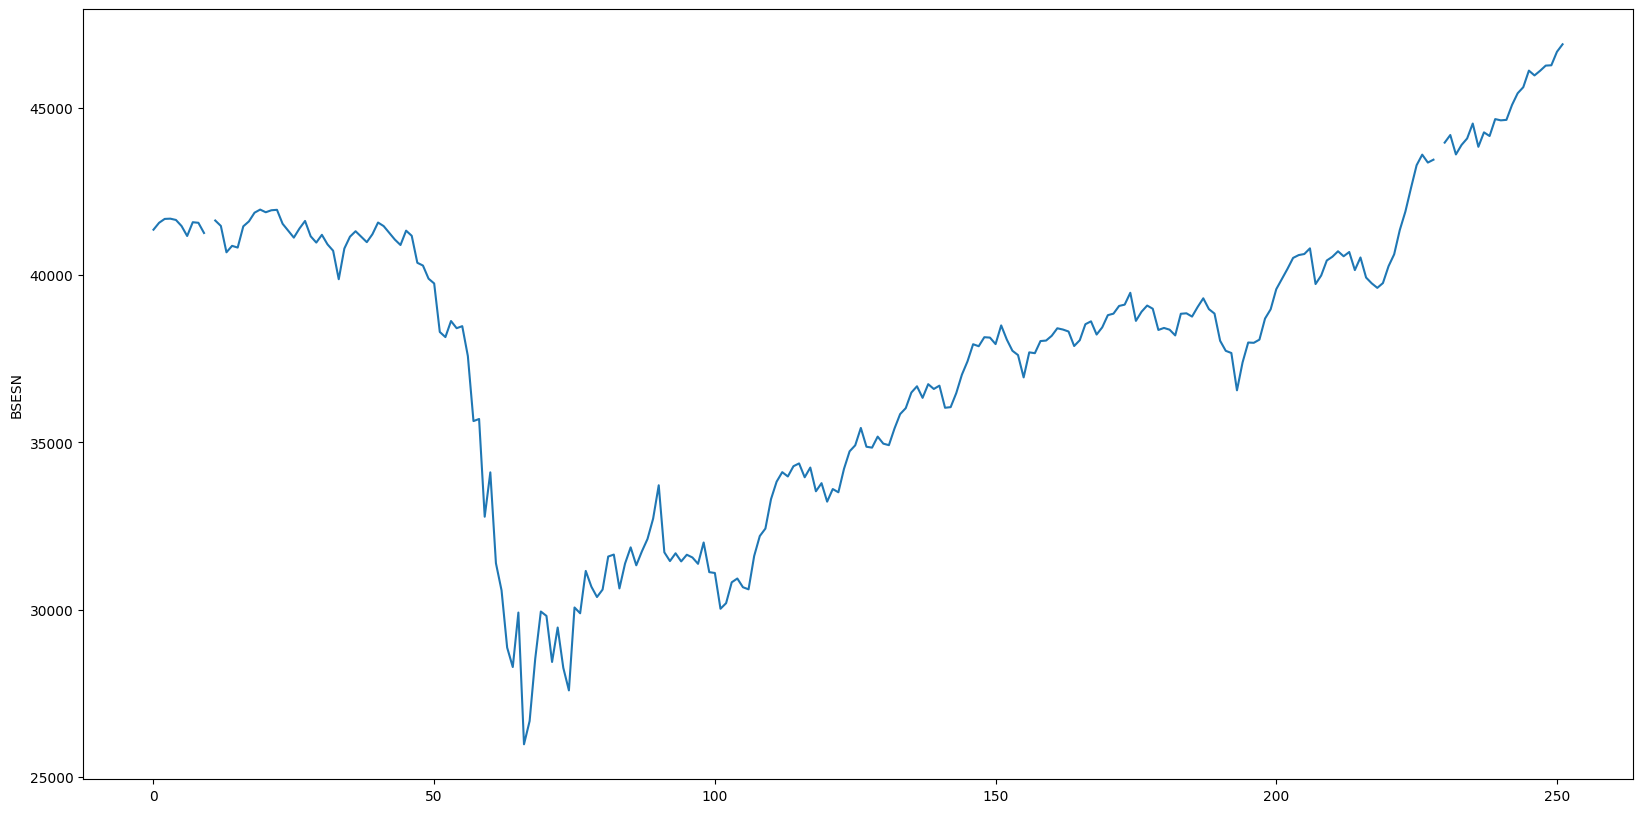

In [ ]:
# Figure plot
plt.figure(figsize=(20,10))
hisdf['Close'].plot()
plt.ylabel('BSESN')

In [ ]:
#removing unwanted characters from the News
ndf.replace("[^a-zA-Z']"," ",regex=True,inplace=True)
ndf["News"].head(5)

,News
0,Status quo will not be disturbed at Ayodhya s...
1,Powerless north India gropes in the dark Think...
2,The string that pulled Stephen Hawking to Indi...
3,Light combat craft takes India into club class...
4,Light combat craft takes India into club class...


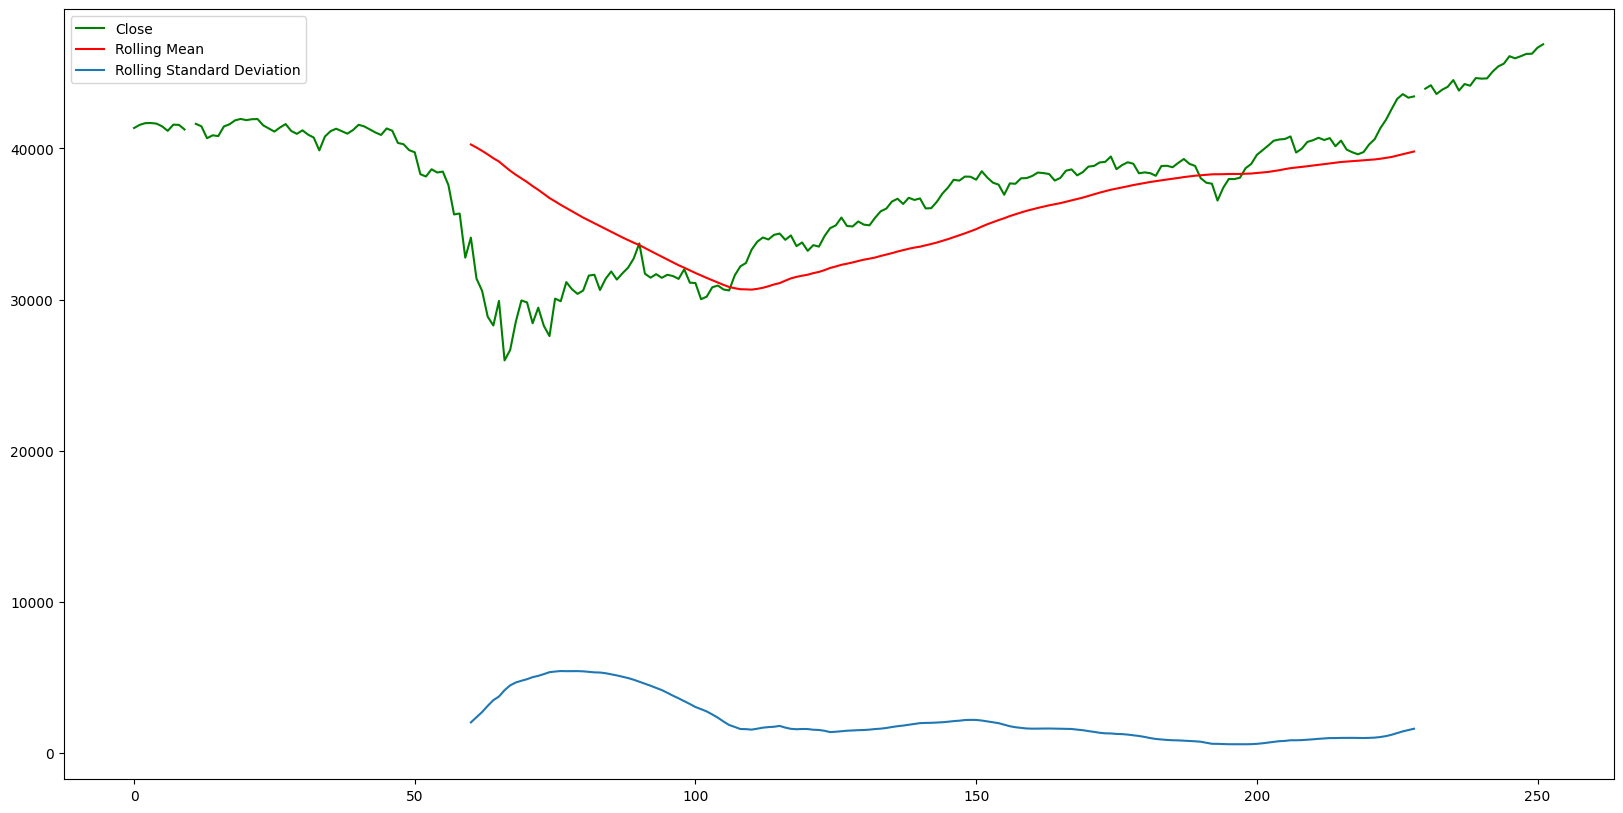

In [ ]:
#Plotting moving average
close = hisdf['Close']

ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(20,10))
hisdf['Close'].plot(color='g',label='Close')
ma.plot(color = 'r',label='Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')

plt.legend()

Text(0.5, 1.0, 'Returns')

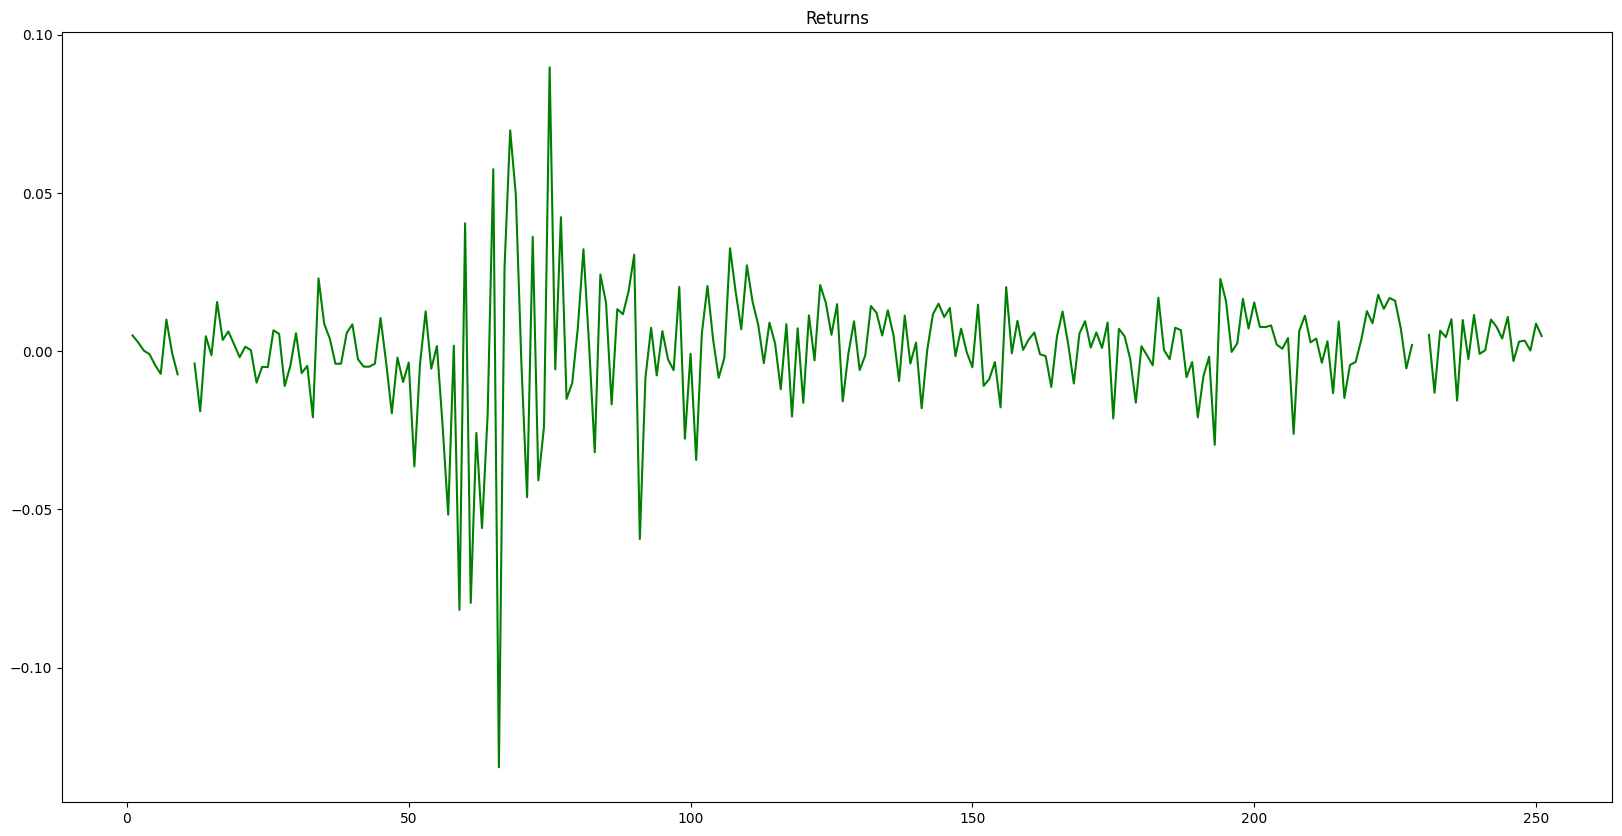

In [ ]:
#Plotting returns
returns = close / close.shift(1) - 1

plt.figure(figsize = (20,10))
returns.plot(label='Return', color = 'g')
plt.title("Returns")

In [ ]:
# Train test split
train = hisdf[:248]
test = hisdf[248:]

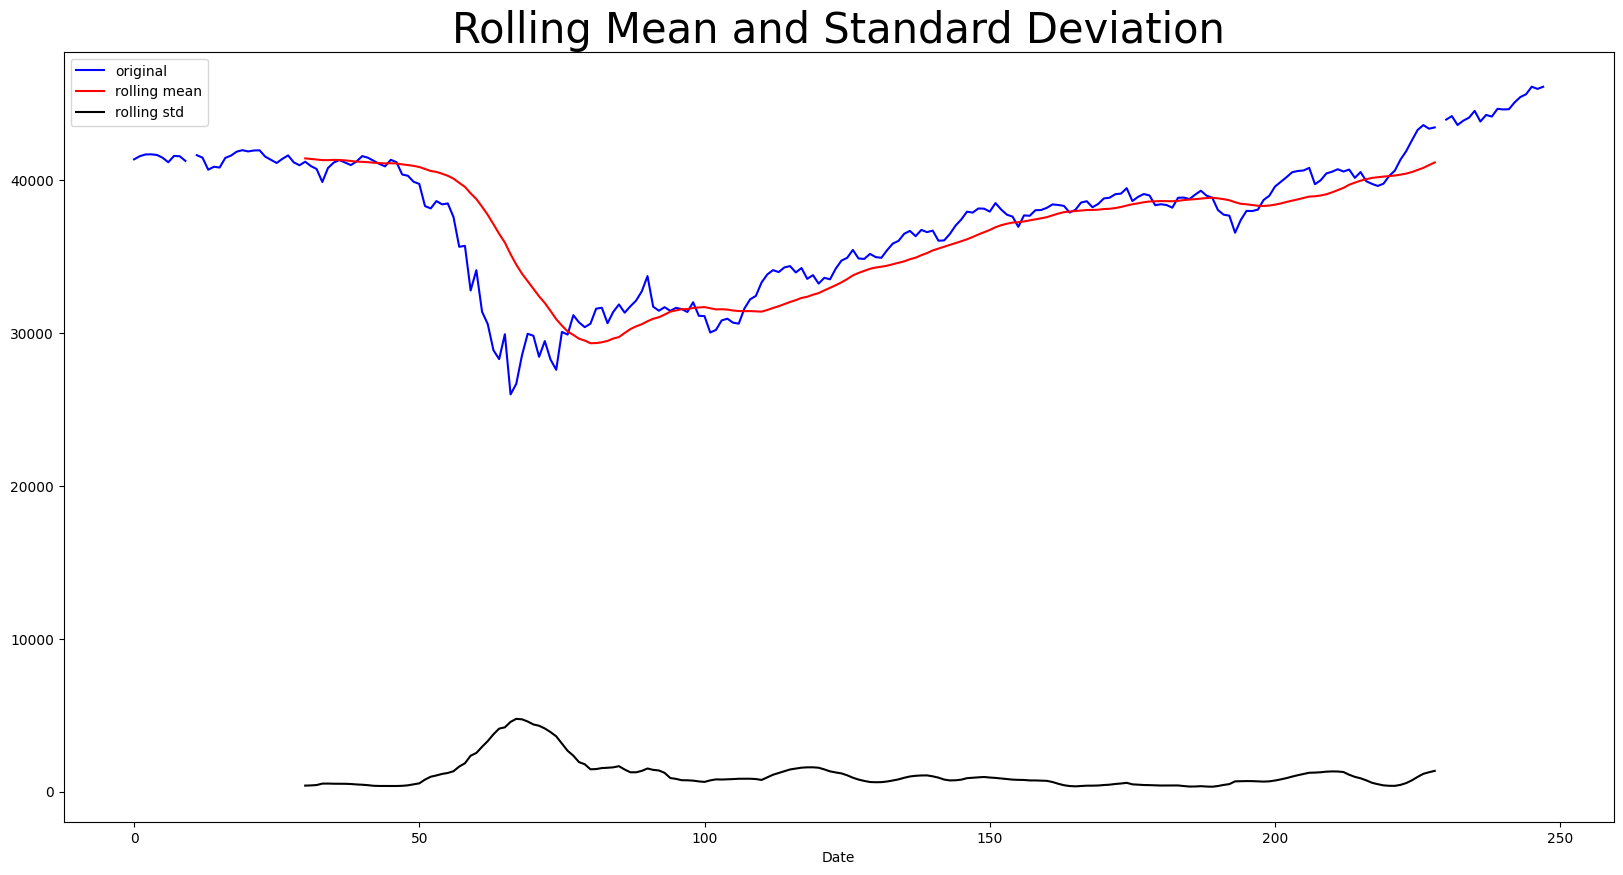

Results of dickey fuller test
ADF Test Statistic : -0.8544716915716797
p-value : 0.8025957500175271
#Lags Used : 6
Number of Observations Used : 239
Weak evidence against null hypothesis, time series is non-stationary 


In [ ]:
#Stationarity test
def test_stationarity(timeseries):

    # Determine the rolling statistics
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()

    # Plot rolling statistics:
    plt.figure(figsize = (20,10))
    plt.plot(timeseries, color = 'blue', label = 'original')
    plt.plot(rolmean, color = 'r', label = 'rolling mean')
    plt.plot(rolstd, color = 'black', label = 'rolling std')
    plt.xlabel('Date')
    plt.legend()
    plt.title('Rolling Mean and Standard Deviation',  fontsize = 30)
    plt.show(block = False)

    print('Results of dickey fuller test')
    # drop NaN values before applying adfuller
    timeseries = timeseries.dropna()
    result = adfuller(timeseries, autolag = 'AIC')

    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result, labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("Weak evidence against null hypothesis, time series is non-stationary ")

test_stationarity(train['Close'])

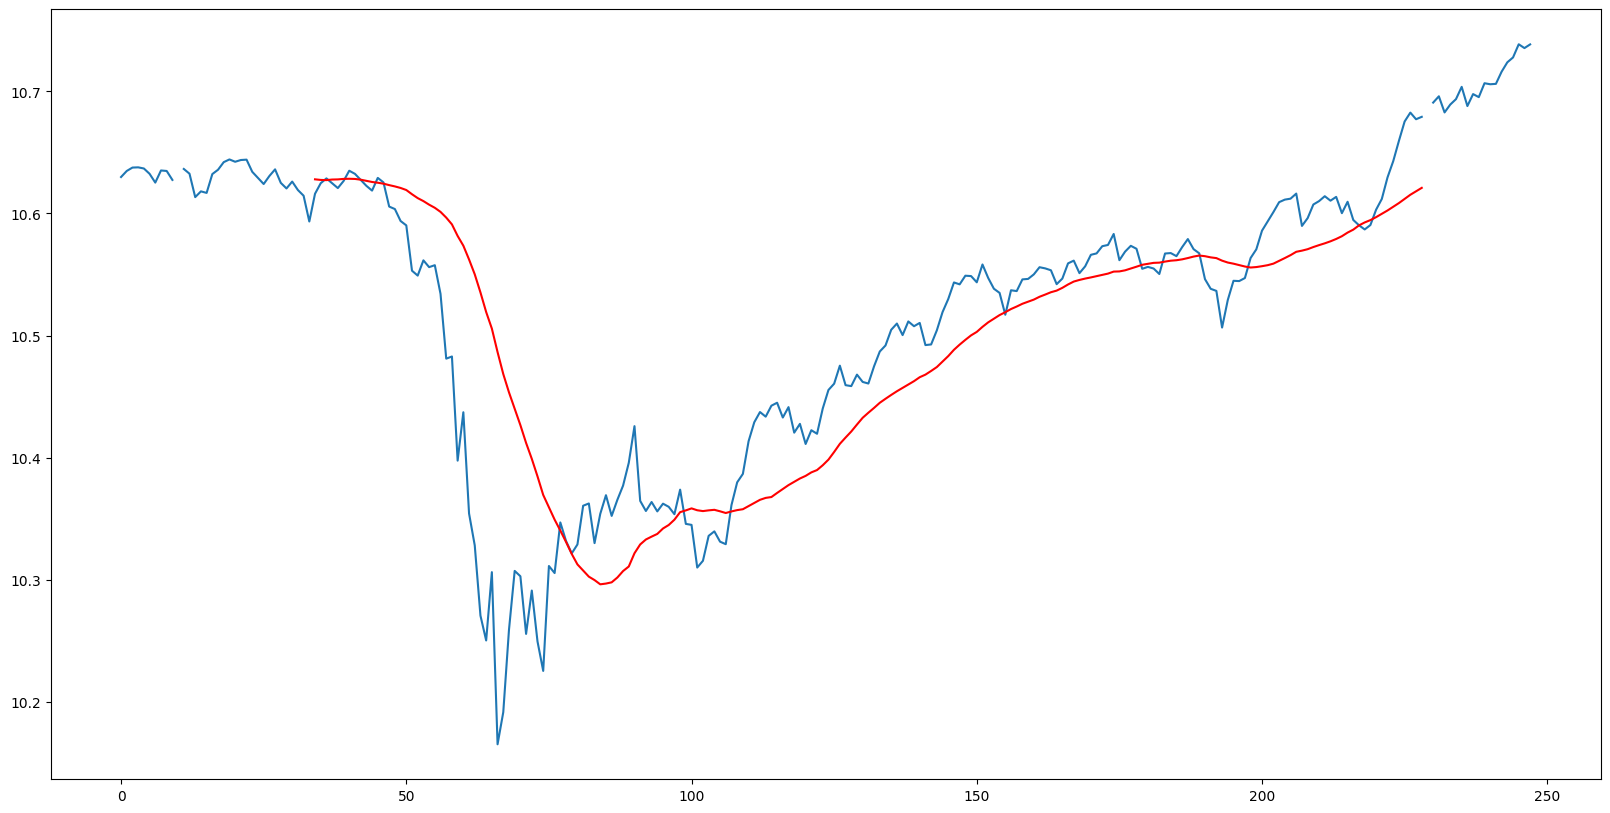

In [ ]:
train_log = np.log(train['Close'])
test_log = np.log(test['Close'])

mav = train_log.rolling(24).mean()
plt.figure(figsize = (20,10))
plt.plot(train_log)
plt.plot(mav, color = 'red')

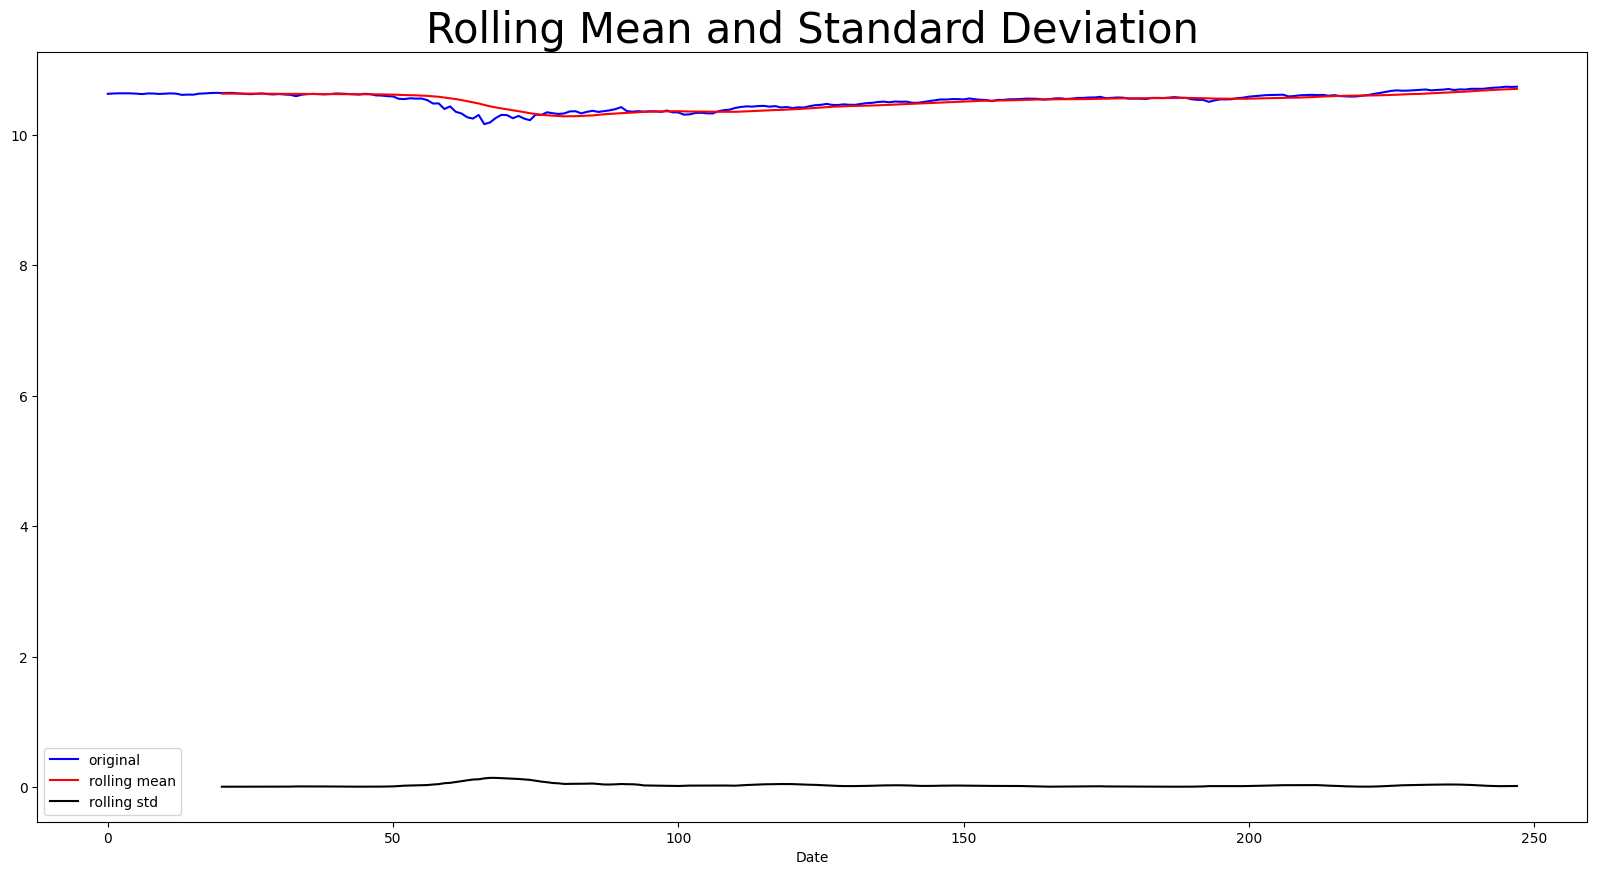

Results of dickey fuller test
ADF Test Statistic : -1.2823150738811913
p-value : 0.6372238539150763
#Lags Used : 7
Number of Observations Used : 238
Weak evidence against null hypothesis, time series is non-stationary 


In [ ]:
train_log.dropna(inplace = True)
test_log.dropna(inplace = True)

test_stationarity(train_log)

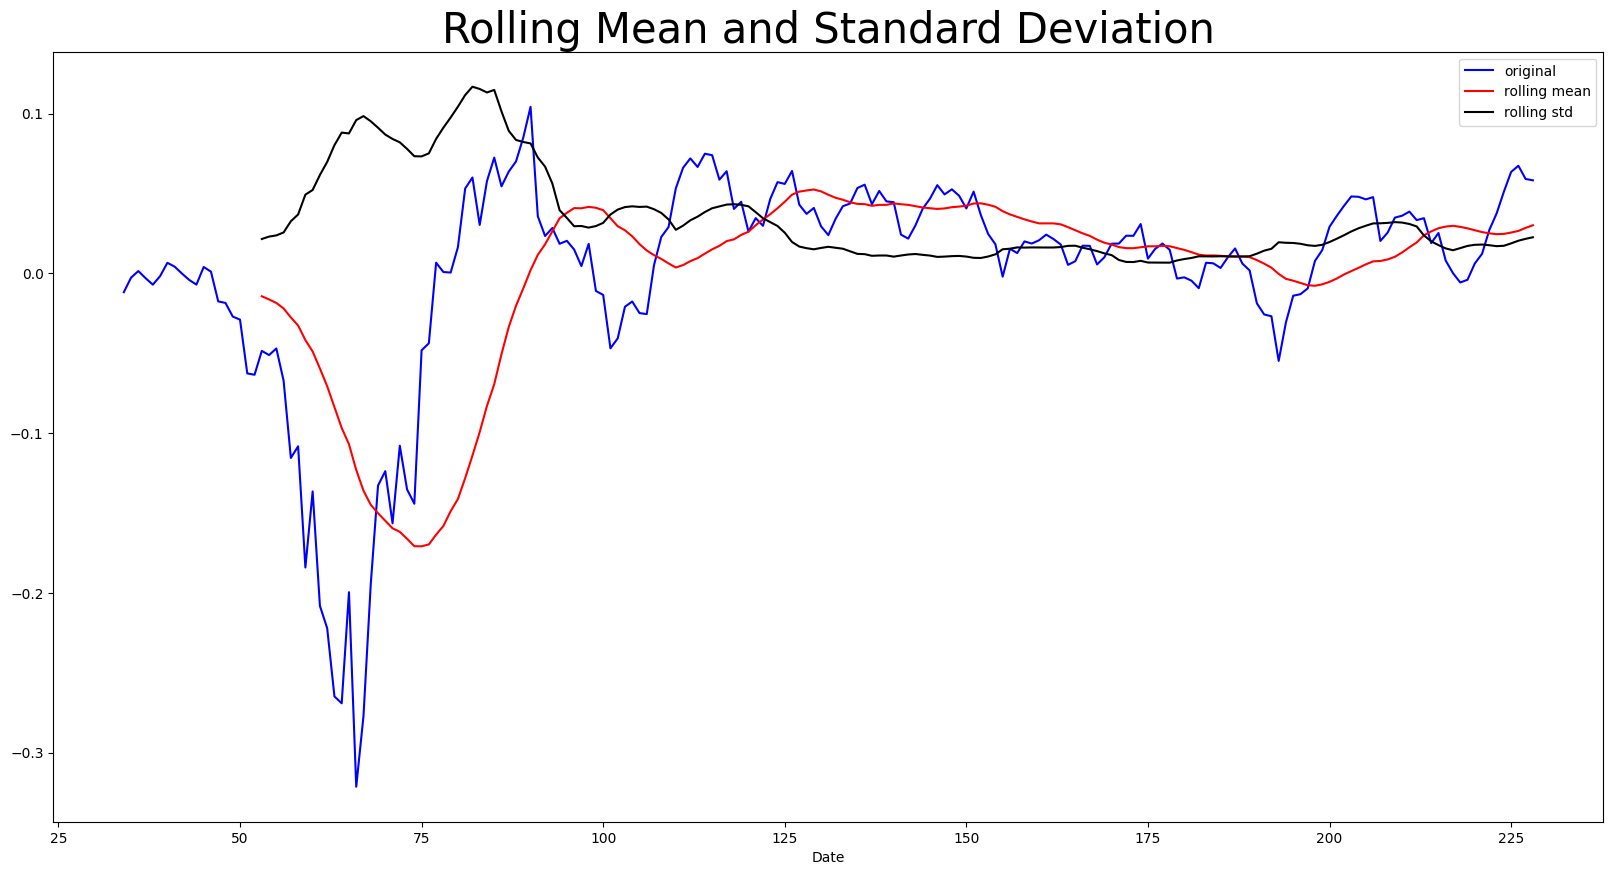

Results of dickey fuller test
ADF Test Statistic : -2.839838982126019
p-value : 0.05280452791340235
#Lags Used : 7
Number of Observations Used : 187
Weak evidence against null hypothesis, time series is non-stationary 


In [ ]:
train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)

test_stationarity(train_log_diff)

In [ ]:
model = auto_arima(train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train_log)
predictions = model.predict(periods = len(test))
predictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1205.554, Time=1.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1205.084, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1207.962, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1207.393, Time=1.67 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1206.970, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1206.463, Time=1.24 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1206.156, Time=0.59 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1204.620, Time=1.46 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1209.813, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-1208.326, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1208.011, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1209.244, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-1210.496, Time=2.70 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-1209.578, Time=2.33 sec
 ARIMA(2,1,2)(0,0,0

Text(0, 0.5, 'Actual Stock Price')

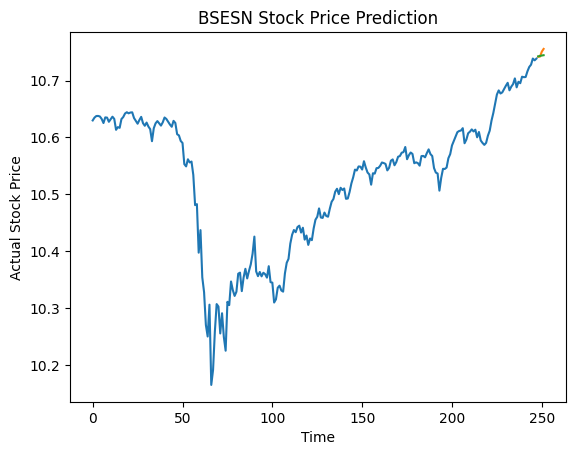

In [ ]:
plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('BSESN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')

In [ ]:
#Calculating error
rms = np.sqrt(mean_squared_error(test_log,predictions))
print("RMSE : ", rms)

RMSE :  0.006528387001853737


In [ ]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [ ]:
#Adding subjectivity and polarity columns
ndf['Subjectivity'] = ndf['News'].apply(getSubjectivity)
ndf['Polarity'] = ndf['News'].apply(getPolarity)
ndf

,Date,News,Subjectivity,Polarity
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590
1,2001-01-03,Powerless north India gropes in the dark Think...,0.392857,0.089286
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039
3,2001-01-05,Light combat craft takes India into club class...,0.480553,0.264024
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485
...,...,...,...,...
228,2001-09-29,SIMI activists held in Maharashtra Progres...,0.363121,0.064056
229,2001-09-30,Lawyers urged to eschew path of agitation Dips...,0.383507,0.034153
230,2001-10-01,IAF picks Bangalore to set up engineering coll...,0.443098,0.017810
231,2001-10-02,News Briefs It was a long excruciating wait a...,0.400776,0.027211


In [ ]:
#Adding sentiment score to df_news
sia = SentimentIntensityAnalyzer()

In [ ]:
ndf['Compound'] = [sia.polarity_scores(v)['compound'] for v in ndf['News']]
ndf['Negative'] = [sia.polarity_scores(v)['neg'] for v in ndf['News']]
ndf['Neutral'] = [sia.polarity_scores(v)['neu'] for v in ndf['News']]
ndf['Positive'] = [sia.polarity_scores(v)['pos'] for v in ndf['News']]
ndf

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590,-0.9792,0.121,0.809,0.071
1,2001-01-03,Powerless north India gropes in the dark Think...,0.392857,0.089286,-0.8910,0.156,0.735,0.109
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039,0.7543,0.104,0.792,0.104
3,2001-01-05,Light combat craft takes India into club class...,0.480553,0.264024,0.9645,0.142,0.694,0.164
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485,-0.8316,0.214,0.655,0.131
...,...,...,...,...,...,...,...,...
228,2001-09-29,SIMI activists held in Maharashtra Progres...,0.363121,0.064056,-0.9997,0.166,0.760,0.074
229,2001-09-30,Lawyers urged to eschew path of agitation Dips...,0.383507,0.034153,-0.9993,0.155,0.751,0.095
230,2001-10-01,IAF picks Bangalore to set up engineering coll...,0.443098,0.017810,-0.9997,0.218,0.713,0.069
231,2001-10-02,News Briefs It was a long excruciating wait a...,0.400776,0.027211,-0.9997,0.185,0.742,0.073


In [ ]:
ndf['Sentiment'] = np.where(ndf['Compound'] >= 0.05, 'Positive', np.where(ndf['Compound'] <= -0.05, 'Negative', 'Neutral'))

In [ ]:
from sklearn.model_selection import train_test_split

X = ndf[['Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral', 'Positive']]
y = ndf['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Adjust test_size and random_state as needed

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
y_pred = model.predict(X_test)

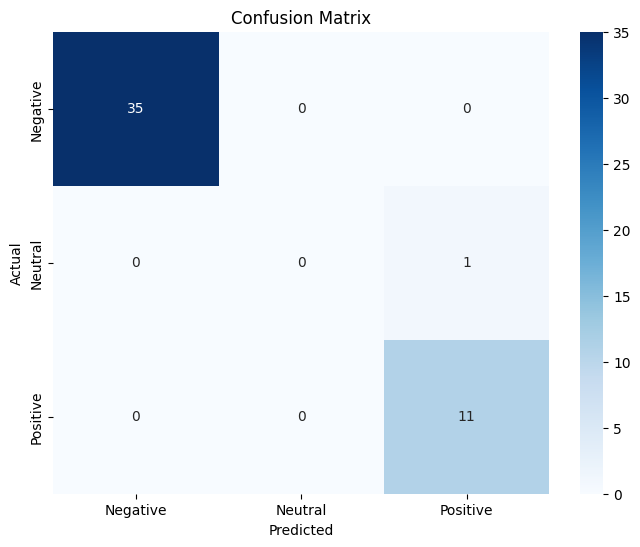

              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        35
     Neutral       0.00      0.00      0.00         1
    Positive       0.92      1.00      0.96        11

    accuracy                           0.98        47
   macro avg       0.64      0.67      0.65        47
weighted avg       0.96      0.98      0.97        47



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report (includes F1 score, recall, precision, etc.)
print(classification_report(y_test, y_pred))

In [ ]:
hisdf["Date"]= pd.to_datetime(hisdf["Date"])
ndf["Date"] = pd.to_datetime(ndf["Date"],format='%Y%m%d')

In [ ]:
df_merge = pd.merge(hisdf, ndf, how='outer', on='Date')
df_merge

,Date,Open,High,Low,Close,Volume,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive,Sentiment
0,2001-01-02,NaN,NaN,NaN,NaN,NaN,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590,-0.9792,0.121,0.809,0.071,Negative
1,2001-01-03,NaN,NaN,NaN,NaN,NaN,Powerless north India gropes in the dark Think...,0.392857,0.089286,-0.8910,0.156,0.735,0.109,Negative
2,2001-01-04,NaN,NaN,NaN,NaN,NaN,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039,0.7543,0.104,0.792,0.104,Positive
3,2001-01-05,NaN,NaN,NaN,NaN,NaN,Light combat craft takes India into club class...,0.480553,0.264024,0.9645,0.142,0.694,0.164,Positive
4,2001-01-06,NaN,NaN,NaN,NaN,NaN,Light combat craft takes India into club class...,0.439394,0.248485,-0.8316,0.214,0.655,0.131,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,2020-12-11,46060.320313,46309.628906,45706.218750,46099.011719,26300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
481,2020-12-14,46284.699219,46373.339844,45951.531250,46253.460938,18400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
482,2020-12-15,46287.390625,46350.300781,45841.671875,46263.171875,16400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
483,2020-12-16,46573.308594,46704.968750,46402.199219,46666.460938,13100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
dfmerge1 = df_merge[['Close','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral', 'Positive']]
dfmerge1

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,NaN,0.286859,0.143590,-0.9792,0.121,0.809,0.071
1,NaN,0.392857,0.089286,-0.8910,0.156,0.735,0.109
2,NaN,0.445360,0.093039,0.7543,0.104,0.792,0.104
3,NaN,0.480553,0.264024,0.9645,0.142,0.694,0.164
4,NaN,0.439394,0.248485,-0.8316,0.214,0.655,0.131
...,...,...,...,...,...,...,...
480,46099.011719,NaN,NaN,NaN,NaN,NaN,NaN
481,46253.460938,NaN,NaN,NaN,NaN,NaN,NaN
482,46263.171875,NaN,NaN,NaN,NaN,NaN,NaN
483,46666.460938,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df = pd.DataFrame(scaler.fit_transform(dfmerge1))
df.columns = dfmerge1.columns
df.index = dfmerge1.index
df.head()

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,NaN,0.286859,0.418803,0.010411,0.272523,0.809,0.116776
1,NaN,0.392857,0.358466,0.054770,0.351351,0.735,0.179276
2,NaN,0.445360,0.362636,0.882261,0.234234,0.792,0.171053
3,NaN,0.480553,0.552619,0.987980,0.319820,0.694,0.269737
4,NaN,0.439394,0.535354,0.084645,0.481982,0.655,0.215461


In [ ]:
X=df.drop('Close',axis=1)
X

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.286859,0.418803,0.010411,0.272523,0.809,0.116776
1,0.392857,0.358466,0.054770,0.351351,0.735,0.179276
2,0.445360,0.362636,0.882261,0.234234,0.792,0.171053
3,0.480553,0.552619,0.987980,0.319820,0.694,0.269737
4,0.439394,0.535354,0.084645,0.481982,0.655,0.215461
...,...,...,...,...,...,...
480,NaN,NaN,NaN,NaN,NaN,NaN
481,NaN,NaN,NaN,NaN,NaN,NaN
482,NaN,NaN,NaN,NaN,NaN,NaN
483,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
Y=df['Close']
Y

,Close
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
480,0.962154
481,0.969541
482,0.970005
483,0.989293


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 0)
x_train.shape

(388, 6)

In [ ]:
x_train[:10]

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
171,0.425970,0.300572,0.001056,0.310811,0.789,0.120066
221,0.402263,0.340052,0.001861,0.290541,0.774,0.159539
454,NaN,NaN,NaN,NaN,NaN,NaN
433,NaN,NaN,NaN,NaN,NaN,NaN
407,NaN,NaN,NaN,NaN,NaN,NaN
219,0.439590,0.376654,0.000453,0.331081,0.751,0.167763
59,0.467396,0.445217,0.114771,0.367117,0.709,0.210526
375,NaN,NaN,NaN,NaN,NaN,NaN
379,NaN,NaN,NaN,NaN,NaN,NaN
154,0.355453,0.275108,0.000201,0.432432,0.695,0.185855


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler


# ... (Your existing code for loading and preprocessing data) ...

# Impute NaN values in dfmerge1 before scaling
imputer = KNNImputer(n_neighbors=5)
dfmerge1_imputed = pd.DataFrame(imputer.fit_transform(dfmerge1), columns=dfmerge1.columns)

# Scale the imputed data
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(dfmerge1_imputed), columns=dfmerge1_imputed.columns)
df.index = dfmerge1_imputed.index

# Now proceed with feature selection and train-test split
X = df.drop('Close', axis=1)
Y = df['Close']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

# Reset indices before fitting the model
x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [ ]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
prediction=rf.predict(x_test)

In [ ]:
print(prediction[:10])
print(y_test[:10])
print('Mean Squared error: ',mean_squared_error(prediction,y_test))
print('Mean Absolute Error (MAE): ', mean_absolute_error(prediction, y_test))

[0.56263608 0.55873746 0.56263608 0.55873746 0.56263608 0.55873746
 0.56263608 0.56263608 0.56263608 0.56263608]
0    0.562636
1    0.222653
2    0.562636
3    0.346622
4    0.562636
5    0.562187
6    0.562636
7    0.562636
8    0.562636
9    0.562636
Name: Close, dtype: float64
Mean Squared error:  0.02980318679062397
Mean Absolute Error (MAE):  0.11263663366061989


In [ ]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor()
dtr.fit(x_train, y_train)
predictions = dtr.predict(x_test)

In [ ]:
print(predictions[:10])
print(y_test[:10])
print('Mean Squared error: ',mean_squared_error(predictions,y_test))
print('Mean Absolute Error (MAE): ', mean_absolute_error(prediction, y_test))

[0.56263608 0.55956996 0.56263608 0.55956996 0.56263608 0.55956996
 0.56263608 0.56263608 0.56263608 0.56263608]
0    0.562636
1    0.222653
2    0.562636
3    0.346622
4    0.562636
5    0.562187
6    0.562636
7    0.562636
8    0.562636
9    0.562636
Name: Close, dtype: float64
Mean Squared error:  0.02978952400057329
Mean Absolute Error (MAE):  0.11263663366061989


In [ ]:
from sklearn.ensemble import AdaBoostRegressor
adb = AdaBoostRegressor()
adb.fit(x_train, y_train)

AdaBoostRegressor()

In [ ]:
predictions = adb.predict(x_test)
print(mean_squared_error(predictions, y_test))
print(mean_absolute_error(predictions,y_test))

0.03008408166364068
0.11425919267982368


In [ ]:
import lightgbm
gbm = lightgbm.LGBMRegressor()
gbm.fit(x_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 337
[LightGBM] [Info] Number of data points in the train set: 388, number of used features: 6
[LightGBM] [Info] Start training from score 0.561087
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

LGBMRegressor()

In [ ]:
predictions =gbm.predict(x_test)
print('Mean Squared error: ',mean_squared_error(predictions,y_test))
print('Mean Absolute Error (MAE): ', mean_absolute_error(prediction, y_test))

Mean Squared error:  0.029789526804262577
Mean Absolute Error (MAE):  0.11263663366061989


In [ ]:
xgb = xgboost.XGBRegressor()
xgb.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
predictions = xgb.predict(x_test)
print('Mean Squared error: ',mean_squared_error(predictions,y_test))
print('Mean Absolute Error (MAE): ', mean_absolute_error(prediction, y_test))


Mean Squared error:  0.029788524490001883
Mean Absolute Error (MAE):  0.11263663366061989
